#### Librerias:


In [1]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, accuracy_score
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, ConfusionMatrixDisplay
from Get_or_Create_Experiment import get_or_create_experiment
from mlflow import MlflowClient

import mlflow
import os 
import boto3
from botocore.client import Config
from mlflow.models.signature import ModelSignature
from mlflow.models.signature import infer_signature



#### <font color='lightgreen'>1. Fuente de información</font>

In [2]:
data = pd.read_csv('weatherAUS.csv', sep=',')

In [3]:
data.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


#### <font color='lightgreen'>2. Preparación de los datos</font>

In [4]:
# Funcion para calcular los rangos a descartar:
def find_skewed_boundaries(dfdt, variable, distance=1.5):
    IQR = dfdt[variable].quantile(0.75) - dfdt[variable].quantile(0.25)
    lower_boundary = dfdt[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = dfdt[variable].quantile(0.75) + (IQR * distance)
    return upper_boundary, lower_boundary

# Función que convierte outliers en valores definidos por 'upper'
def censura(x, col, upper, lower):
    return np.where(x[col] > upper, upper,
                       np.where(x[col] < lower, lower, x[col]))

# Transformación de la columna de fecha
data['Date'] = pd.to_datetime(data['Date'])  # Convertimos a tipo de dato 'datetime'
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data.drop('Date', axis=1, inplace=True)

# Reducimos cardinalidad de variables de vientos:
data['WindGustDir'] = data['WindGustDir'].astype(str).str[0]
data['WindDir9am'] = data['WindDir9am'].astype(str).str[0]
data['WindDir3pm']= data['WindDir3pm'].astype(str).str[0]

# Se Eliminan filas con valores faltantes en la variable de salida ('RainTomorrow')
data = data.dropna(subset=['RainTomorrow'])

# Dividimos los datos en entrada (X) y salida (y)
X = data.drop(columns=['RainTomorrow'])  # Entrada
y = data['RainTomorrow']  # Salida

y = y.map({'Yes': 1, 'No': 0})

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definimos las columnas numéricas y categóricas
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Censura de outliers, solo variables con grandes cantidades
col = ['Rainfall', 'Evaporation', 'WindSpeed9am', 'WindSpeed3pm']

upper, lower = find_skewed_boundaries(X_train, col, 1.5)
X_train[col] = censura(X_train, col, upper, lower)
upper, lower = find_skewed_boundaries(X_train, col, 1.5)
X_test[col] = censura(X_test, col, upper, lower)

# Definimos las transformaciones para las columnas numéricas (podriamos usar mean o most_frequent)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Definimos las transformaciones para las columnas categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combinamos las transformaciones en un preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [5]:
data.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Year,Month,Day
count,141556.000000,141871.000000,140787.000000,81350.000000,74377.000000,132923.000000,140845.000000,139563.000000,140419.000000,138583.000000,128179.000000,128212.000000,88536.000000,85099.000000,141289.000000,139467.000000,142193.000000,142193.000000,142193.000000
mean,12.186400,23.226784,2.349974,5.469824,7.624853,39.984292,14.001988,18.637576,68.843810,51.482606,1017.653758,1015.258204,4.437189,4.503167,16.987509,21.687235,2012.758926,6.402544,15.715084
std,6.403283,7.117618,8.465173,4.188537,3.781525,13.588801,8.893337,8.803345,19.051293,20.797772,7.105476,7.036677,2.887016,2.720633,6.492838,6.937594,2.541256,3.426506,8.798150
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000,2007.000000,1.000000,1.000000
25%,7.600000,17.900000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.300000,16.600000,2011.000000,3.000000,8.000000
50%,12.000000,22.600000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000,2013.000000,6.000000,16.000000
75%,16.800000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000,2015.000000,9.000000,23.000000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000,2017.000000,12.000000,31.000000


#### <font color='lightgreen'>3. Entrenamiento de modelos</font>  
Solo tome el mejor.

In [6]:
# Definimos los modelos candidatos.
model = RandomForestClassifier(random_state=42)

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Entrenamos el modelo
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday'], dtype='object'))])),
                ('classifier', RandomForestClassifier(random_state=42))])

#### <font color='lightgreen'>4. Metricas</font>  

In [7]:
# Guardo el modelo en un archivo .pkl, ya que tardo 7 min el entrenamiento.
with open('model.pkl', 'wb') as archivo:
    pickle.dump(model_pipeline, archivo)

In [6]:
# Cargo el modelo desde el archivo .pkl
with open('model.pkl', 'rb') as archivo:
    model = pickle.load(archivo)

Modelo - Accuracy: 0.8534055346531172
Modelo - Precision: 0.7561320754716981


C:\Users\franco\AppData\Local\Temp\ipykernel_11212\2560574716.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


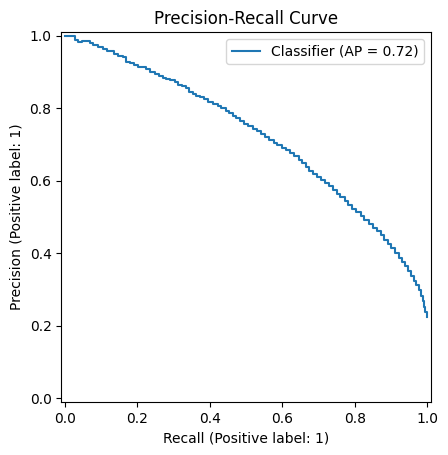

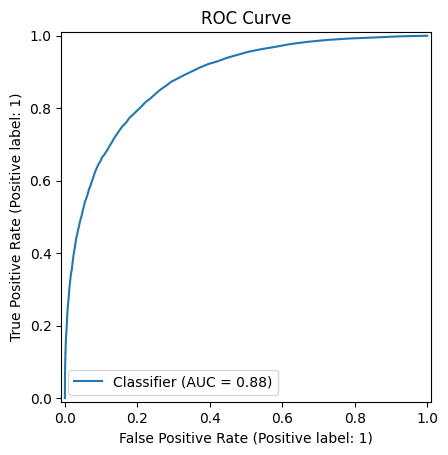

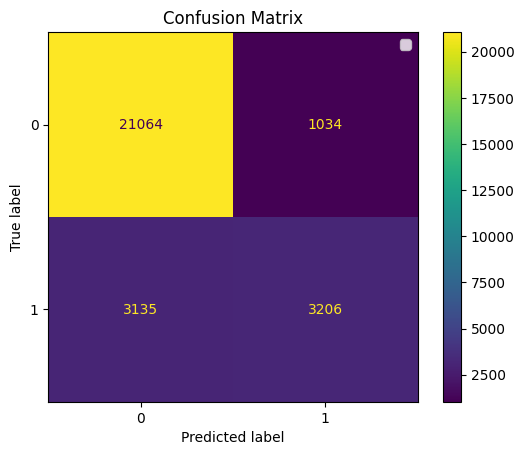

In [7]:
# Generamos la predicción en el conjunto de prueba
y_pred = model.predict(X_test)
y_test_prob = model.predict_proba(X_test)[:, 1]

# Calculamos la accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Modelo - Accuracy: {accuracy}")

# Calculamos la precisión
precision = precision_score(y_test, y_pred)
print(f"Modelo - Precision: {precision}")

# Calculamos la curva de precision-recall
fig_pr = plt.figure()
pr_display = PrecisionRecallDisplay.from_predictions(y_test, y_test_prob, ax=plt.gca())
plt.title("Precision-Recall Curve")
plt.legend()

#calculamos la curva Roc
fig_roc = plt.figure()
roc_display = RocCurveDisplay.from_predictions(y_test, y_test_prob, ax=plt.gca())
plt.title("ROC Curve")
plt.legend()

#calculamos la matriz de confución
fig_cm = plt.figure()
cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=plt.gca())
plt.title("Confusion Matrix")
plt.legend()

#### <font color='lightgreen'>5. Almacenamos el modelo en MLflow</font>  

In [8]:
#Establecer las variables de entorno
os.environ["AWS_ACCESS_KEY_ID"] = "minio"
os.environ["AWS_SECRET_ACCESS_KEY"] = "minio123"
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "http://localhost:9000"
os.environ["S3_SIGNATURE_VERSION"] = "unsigned"
os.environ["MLFLOW_TRACKING_URI"] = "http://localhost:5000"
client = boto3.client('s3', config=Config(signature_version=os.environ.get("S3_SIGNATURE_VERSION", "s3v4")))
mlflow.set_tracking_uri('http://localhost:5000') 

In [9]:
# Create the Experiment, providing a unique name
raining_model_experiment_id = get_or_create_experiment(
    experiment_name="Raining_Prediction_Model"
)

In [10]:
# Descripción del experimento
experiment_description = (
    "Este projecto se basa en la predicción de lluvia al día siguiente en localidades de Australia. "
    "Este experimento contiene el modelo para hacer las predicciones, como las metricas que caracterizan la capacidad de este."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "Raining-tomorrow",
    "store_dept": "AdM1",
    "team": "Camilo-Kevin-Franco",
    "mlflow.note.content": experiment_description,
}

# Con la signature se especifica los tipos de datos de las entradas y las salidas del modelo.
model_signature = infer_signature(X_train[:10], y_train[:10], params={"model_name": "model"})

#creamos un run
with mlflow.start_run(run_name = "testing", experiment_id = raining_model_experiment_id) as run:
    
    # almacenamos los tags y descripción del experimento, pero no esta funcionando
    mlflow.set_experiment_tags(experiment_tags)

    # log metrics
    metrics = {
        'Accuracy': 0.8534,
        'Precision': 0.7561
    }
    mlflow.log_metrics(metrics)

    # log figures:
    mlflow.log_figure(fig_roc, "metrics/roc_curve.png")
    mlflow.log_figure(fig_cm, "metrics/cm.png")
    mlflow.log_figure(fig_pr, "metrics/pr.png")

    # log model and register model
    mlflow.sklearn.log_model(sk_model=model, artifact_path="random_forest_classifier", signature=model_signature, registered_model_name='registered_model')

    # print info about the run
    print("run_id: {}".format(run.info.run_id))
    print("experiment_id: {}".format(run.info.experiment_id))
    print("status: {}".format(run.info.status))
    print("start_time: {}".format(run.info.start_time))
    print("end_time: {}".format(run.info.end_time))
    print("lifecycle_stage: {}".format(run.info.lifecycle_stage))

c:\Users\franco\OneDrive\Escritorio\ESPECIALIZACIO_EN_INTELIGENCIA_ARTIFICIAL\aprendizaje_maquina_II\am2\lib\site-packages\mlflow\types\utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'registered_model'.
2024/06/07 11:48:42 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to

run_id: f60b26d4cd764bb29d9f6fa360fb2dfa
experiment_id: 2
status: RUNNING
start_time: 1717771704497
end_time: None
lifecycle_stage: active


Created version '1' of model 'registered_model'.


In [11]:
#seteamos alias y tags del modelo registrado para poder identificarlo cuando sea necesario:
with mlflow.start_run(run_name = "tags_and_alias_of_model_registered", experiment_id = raining_model_experiment_id) as run:    
    #set tag and alias to then we can access.
    client = mlflow.MlflowClient()
    
    client.set_model_version_tag(name='registered_model', version="1", key="Model_status", value="Ready for production")

    client.set_registered_model_alias(name='registered_model', version="1", alias="Champion")
    

### LO QUE SIGUE ES PARA METER DE ENTRADA AL MODELO Y PROBARLO:

In [17]:
result_dict = {key: value for key, value in zip(X_test.columns, X_test.iloc[22, :].values)}

print("{")

for key, val in result_dict.items():

    print("\"{0}\":".format(key), end="")

    if type(val) == str:

        print(" \"{0}\",".format(val))

    else:

        print(" {0},".format(val))

print("}")

{
"Location": "NorfolkIsland",
"MinTemp": 22.6,
"MaxTemp": 27.0,
"Rainfall": 1.0,
"Evaporation": 4.8,
"Sunshine": 4.6,
"WindGustDir": "N",
"WindGustSpeed": 44.0,
"WindDir9am": "N",
"WindDir3pm": "W",
"WindSpeed9am": 20.0,
"WindSpeed3pm": 13.0,
"Humidity9am": 88.0,
"Humidity3pm": 78.0,
"Pressure9am": 1015.8,
"Pressure3pm": 1014.2,
"Cloud9am": 7.0,
"Cloud3pm": 7.0,
"Temp9am": 24.6,
"Temp3pm": 25.6,
"RainToday": "No",
"Year": 2016,
"Month": 2,
"Day": 29,
}


In [135]:
model.predict(X_test.iloc[22, :].to_frame().transpose())

array([1], dtype=int64)